In [1]:
#import jax.numpy as np
#from jax import jit, random, vmap
#from jax.ops import index_add, index_update, index
import matplotlib.pyplot as plt
import functools
from scipy.special import gamma
from scipy.stats import binom_test
import numpy as np
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
mainDirectory = '/content/gdrive/My Drive/COVID19 Eviction Modeling/'

In [4]:
thisFileEvict="evict1_0" # case to use for all trajectories

In [5]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('lines',linewidth=2)
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE, frameon=False)    # legend fontsize
plt.rcParams.update({'axes.spines.top': False, 'axes.spines.right': False})
plt.rcParams['pdf.fonttype'] = 42

In [6]:
def get_daily_iter(soln_cum,tvec):

  """
  Calculates daily incidence for multiple runs
  soln_cum: 2D array of cumulative values for each variable at each timepoint
  tvec: 1D vector of timepoints
  """
  
  Tmax=int(tvec[-1])
  delta_t=tvec[1]-tvec[0]
  total_steps=int(Tmax/delta_t)

  # get daily incidence

  per_day=int(1/delta_t) # number of entries per day
  days_ind=np.arange(start=0,stop=total_steps,step=per_day)

  soln_inc=np.zeros((np.shape(soln_cum)[0],Tmax-1,np.shape(soln_cum)[2]))

  for i in range(0,7):
    daily_cumulative_history=soln_cum[:,days_ind,i] # first pick out entries corresponding to each day
    #soln_inc=index_add(soln_inc,index[:,:,i],daily_cumulative_history[:,1:Tmax]-daily_cumulative_history[:,0:(Tmax-1)]) # then get differences between each day
    soln_inc[:,:,i]=soln_inc[:,:,i]+daily_cumulative_history[:,1:Tmax]-daily_cumulative_history[:,0:(Tmax-1)] # then get differences between each day
  return soln_inc


In [7]:
def smooth_timecourse(soln,o):
  """
  replaces each entry with the moving average over time
  soln: solution vector, 3D array, to smooth. Assumes time is second dimension
  o: # of days (entries) on either side of the current value to average over. o=3 -> 1 week
  """
  soln_smooth=soln
  for iter in range(np.shape(soln)[0]):
    for var in range(np.shape(soln)[2]):
      z=moving_average(soln[iter,:,var],1)
      #soln_smooth=index_update(soln_smooth,index[iter,:,var],z)
      soln_smooth[iter,:,var]=z
  return soln_smooth

def moving_average(x, o):
  """
  x: array to take moving average og
  o: # of days (entries) on either side of the current value to average over
  """
  w=o*2+1 # width of window to average over, current day in center of window
  y=np.convolve(x, np.ones(w), 'full')
  den=np.concatenate((np.arange(o+1,w),w*np.ones(len(x)-w+1),np.arange(w-1,o,step=-1)))
  z=y[o:-o]/den
  return z

# Strong lockdown + comeback

In [8]:
# import files of interest

thisFolder = "lock90relax75" #folder to save things in

# import baseline case
thisFile="baseline"

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_soln.pickle'
file = open(dataFile, 'rb')
soln = pickle.load(file)
file.close()

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_soln_cum.pickle'
file = open(dataFile, 'rb')
soln_cum = pickle.load(file)
file.close()

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_tvec.pickle'
file = open(dataFile, 'rb')
tvec = pickle.load(file)
file.close()

#import eviction case

thisFile=thisFileEvict

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_soln.pickle'
file = open(dataFile, 'rb')
soln_evict = pickle.load(file)
file.close()

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_soln_cum.pickle'
file = open(dataFile, 'rb')
soln_cum_evict = pickle.load(file)
file.close()

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_tvec.pickle'
file = open(dataFile, 'rb')
tvec_evict = pickle.load(file)
file.close()

#import the summary table

dataFile=mainDirectory + 'results/'+thisFolder+'/finalsize.csv'
finalsize = np.genfromtxt(dataFile, delimiter=',',skip_header=0)

In [9]:
dataFile=mainDirectory + 'results/'+thisFolder+'/finalsize.csv'
finalsize = np.genfromtxt(dataFile, delimiter=',',skip_header=1)

fileHeader=np.array(['evictRate','FinalSizeMed','FinalSizeL','FinalSizeU','delFinalSizeMed','delFinalSizeL','delFinalSizeU','fcFinalSizeMed','fcFinalSizeL','fcFinalSizeU','numDiffFinalSize','delFinalSizeP','probInfNoMerg','probInfMerg'])
evictRate=finalsize[:,0]
FinalSizeMed=finalsize[:,1]
FinalSizeL=finalsize[:,2]
FinalSizeU=finalsize[:,3]
delFinalSizeMed=finalsize[:,4]
delFinalSizeL=finalsize[:,5]
delFinalSizeU=finalsize[:,6]
fcFinalSizeMed=finalsize[:,7]
fcFinalSizeL=finalsize[:,8]
fcFinalSizeU=finalsize[:,9]
numDiffFinalSize=finalsize[:,10]
delFinalSizeP=finalsize[:,11]
probInfNoMerg=finalsize[:,12]
probInfMerg=finalsize[:,13]


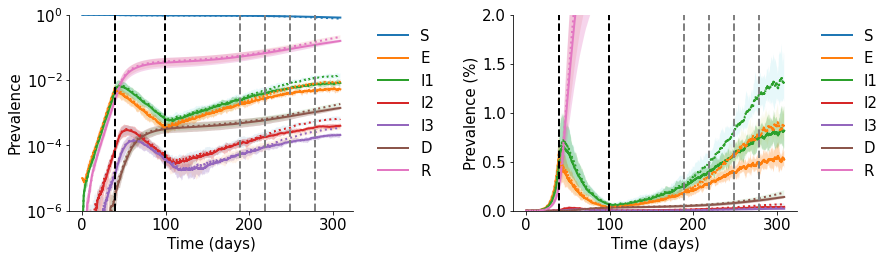

In [10]:
# Plot average trajectory with and without evictions
pop=1e6
ymax=1
scale=1
intOn=1
Tint=39
relax=1
Trelax=Tint+60

evict=1
number_merges = 3
T_start_merge = 90 # time after last intervention that mergers start (days)
T_int_merge = 30 # interval between merges (days)
T_merge_vec=Trelax+np.arange(T_start_merge,T_start_merge*(number_merges+1),T_int_merge)

loCI=5
upCI=95

soln_avg=np.average(soln,axis=0)
soln_loCI=np.percentile(soln,loCI,axis=0)
soln_upCI=np.percentile(soln,upCI,axis=0)

soln_evict_avg=np.average(soln_evict,axis=0)
soln_evict_loCI=np.percentile(soln_evict,loCI,axis=0)
soln_evict_upCI=np.percentile(soln_evict,upCI,axis=0)

# log scale

plt.figure(figsize=(2*6.4, 4.0))
plt.subplot(121)

# add averages
plt.plot(tvec,soln_avg*scale)
plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
for i in range(0,7):
  plt.fill_between(tvec,soln_loCI[:,i]*scale,soln_upCI[:,i]*scale,alpha=0.3)

# add post eviction on top
plt.plot(tvec,soln_evict_avg*scale,':')
for i in range(0,7):
  plt.fill_between(tvec,soln_evict_loCI[:,i]*scale,soln_evict_upCI[:,i]*scale,alpha=0.1)

if intOn==1:
  plt.plot([Tint,Tint],[scale/pop,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[scale/pop,ymax*scale],'k--')

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[scale/pop,ymax*scale],'--',color='gray')

plt.ylim([scale/pop,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Prevalence")
plt.semilogy()

plt.subplot(122)
scale=100
ymax=0.02
ymin=0
plt.plot(tvec,soln_avg*scale)
plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
for i in range(0,7):
  plt.fill_between(tvec,soln_loCI[:,i]*scale,soln_upCI[:,i]*scale,alpha=0.3)

# add post eviction on top
plt.plot(tvec,soln_evict_avg*scale,':')
for i in range(0,7):
  plt.fill_between(tvec,soln_evict_loCI[:,i]*scale,soln_evict_upCI[:,i]*scale,alpha=0.1)


if intOn==1:
  plt.plot([Tint,Tint],[ymin,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[ymin,ymax*scale],'k--')

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[ymin,ymax*scale],'--',color='gray')

plt.ylim([ymin,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Prevalence (%)")


plt.tight_layout()

# if plotThis==True:
#   plt.savefig(plotName+'.pdf',bbox_inches='tight')

plt.show()

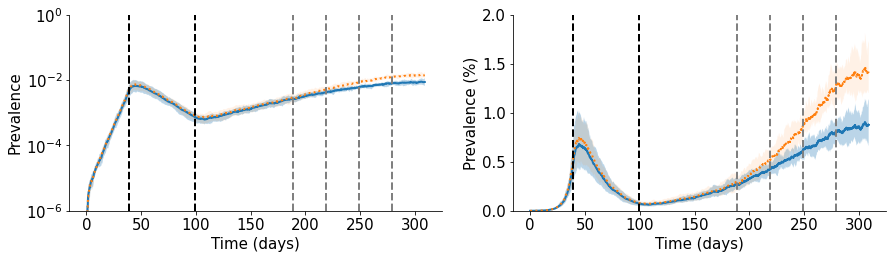

In [11]:
# same but for total infected only 

# Plot average trajectory with and without evictions
pop=1e6
ymax=1
scale=1
intOn=1
Tint=39
relax=1
Trelax=Tint+60

evict=1
number_merges = 3
T_start_merge = 90 # time after last intervention that mergers start (days)
T_int_merge = 30 # interval between merges (days)
T_merge_vec=Trelax+np.arange(T_start_merge,T_start_merge*(number_merges+1),T_int_merge)

loCI=5
upCI=95

soln_avg=np.average(soln,axis=0)
soln_loCI=np.percentile(soln,loCI,axis=0)
soln_upCI=np.percentile(soln,upCI,axis=0)

soln_evict_avg=np.average(soln_evict,axis=0)
soln_evict_loCI=np.percentile(soln_evict,loCI,axis=0)
soln_evict_upCI=np.percentile(soln_evict,upCI,axis=0)

# log scale

plt.figure(figsize=(2*6.4, 4.0))
plt.subplot(121)

# add averages
plt.plot(tvec,np.sum(soln_avg[:,2:5],axis=1)*scale)
plt.plot(tvec,np.sum(soln_evict_avg[:,2:5],axis=1)*scale,':')
#plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
#for i in range(0,7):
plt.fill_between(tvec,np.sum(soln_loCI[:,2:5],axis=1)*scale,np.sum(soln_upCI[:,2:5],axis=1)*scale,alpha=0.3)
plt.fill_between(tvec,np.sum(soln_evict_loCI[:,2:5],axis=1)*scale,np.sum(soln_evict_upCI[:,2:5],axis=1)*scale,alpha=0.1)

if intOn==1:
  plt.plot([Tint,Tint],[scale/pop,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[scale/pop,ymax*scale],'k--')

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[scale/pop,ymax*scale],'--',color='gray')

plt.ylim([scale/pop,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Prevalence")
plt.semilogy()

plt.subplot(122)
scale=100
ymax=0.02
ymin=0
plt.plot(tvec,np.sum(soln_avg[:,2:5],axis=1)*scale)
plt.plot(tvec,np.sum(soln_evict_avg[:,2:5],axis=1)*scale,':') # add post eviction on top

#plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
plt.fill_between(tvec,np.sum(soln_loCI[:,2:5],axis=1)*scale,np.sum(soln_upCI[:,2:5],axis=1)*scale,alpha=0.3)
plt.fill_between(tvec,np.sum(soln_evict_loCI[:,2:5],axis=1)*scale,np.sum(soln_evict_upCI[:,2:5],axis=1)*scale,alpha=0.1)

if intOn==1:
  plt.plot([Tint,Tint],[ymin,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[ymin,ymax*scale],'k--')

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[ymin,ymax*scale],'--',color='gray')

plt.ylim([ymin,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Prevalence (%)")

plt.tight_layout()

plt.show()

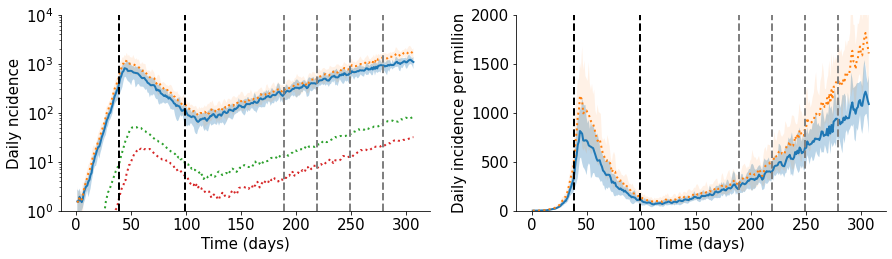

In [12]:
# Plot smoothed incidence

soln_inc=get_daily_iter(soln_cum,tvec)
soln_inc_smooth = smooth_timecourse(soln_inc,3)

soln_inc_evict=get_daily_iter(soln_cum_evict,tvec)
soln_inc_evict_smooth = smooth_timecourse(soln_inc_evict,3)

tvec2=np.arange(1,np.shape(soln_inc)[1]+1)

# same but for total infected only 

# Plot average trajectory with and without evictions
pop=1e6
ymax=0.01
scale=pop
intOn=1
Tint=39
relax=1
Trelax=Tint+60

evict=1
number_merges = 3
T_start_merge = 90 # time after last intervention that mergers start (days)
T_int_merge = 30 # interval between merges (days)
T_merge_vec=Trelax+np.arange(T_start_merge,T_start_merge*(number_merges+1),T_int_merge)

loCI=5
upCI=95

soln_avg=np.average(soln_inc_smooth,axis=0)
soln_loCI=np.percentile(soln_inc_smooth,loCI,axis=0)
soln_upCI=np.percentile(soln_inc_smooth,upCI,axis=0)

soln_evict_avg=np.average(soln_inc_evict_smooth,axis=0)
soln_evict_loCI=np.percentile(soln_inc_evict_smooth,loCI,axis=0)
soln_evict_upCI=np.percentile(soln_inc_evict_smooth,upCI,axis=0)

# log scale

plt.figure(figsize=(2*6.4, 4.0))
plt.subplot(121)

# add averages
plt.plot(tvec2,soln_avg[:,2]*scale)
plt.plot(tvec2,soln_evict_avg[:,2:5]*scale,':')
#plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
#for i in range(0,7):
plt.fill_between(tvec2,soln_loCI[:,2]*scale,soln_upCI[:,2]*scale,alpha=0.3)
plt.fill_between(tvec2,soln_evict_loCI[:,2]*scale,soln_evict_upCI[:,2]*scale,alpha=0.1)

if intOn==1:
  plt.plot([Tint,Tint],[scale/pop,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[scale/pop,ymax*scale],'k--')

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[scale/pop,ymax*scale],'--',color='gray')

plt.ylim([scale/pop,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Daily ncidence")
plt.semilogy()

plt.subplot(122)
scale=pop
ymax=0.002
ymin=0
plt.plot(tvec2,soln_avg[:,2]*scale)
plt.plot(tvec2,soln_evict_avg[:,2]*scale,':') # add post eviction on top

#plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
plt.fill_between(tvec2,soln_loCI[:,2]*scale,soln_upCI[:,2]*scale,alpha=0.3)
plt.fill_between(tvec2,soln_evict_loCI[:,2]*scale,soln_evict_upCI[:,2]*scale,alpha=0.1)

if intOn==1:
  plt.plot([Tint,Tint],[ymin,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[ymin,ymax*scale],'k--')

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[ymin,ymax*scale],'--',color='gray')

plt.ylim([ymin,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Daily incidence per million")

plt.tight_layout()

plt.show()


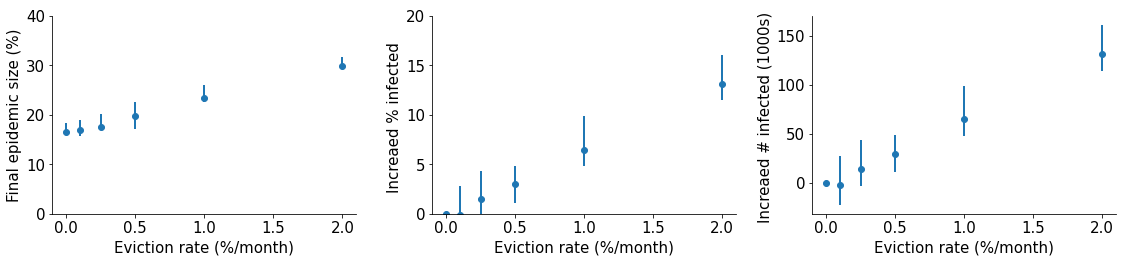

In [13]:
# Final epidemic size

plt.figure(figsize=(2.5*6.4, 4.0))

plt.subplot(131)
FinalSizeRange=[FinalSizeMed-FinalSizeL, FinalSizeU-FinalSizeMed]
plt.errorbar(evictRate,FinalSizeMed,yerr=FinalSizeRange,fmt='o')
plt.xlabel("Eviction rate (%/month)")
plt.ylabel("Final epidemic size (%)")
plt.ylim([0,40])

plt.subplot(132)
delFinalSizeRange=[delFinalSizeMed-delFinalSizeL, delFinalSizeU-delFinalSizeMed]
plt.errorbar(evictRate,delFinalSizeMed,yerr=delFinalSizeRange,fmt='o')
plt.xlabel("Eviction rate (%/month)")
plt.ylabel("Increaed % infected ")
plt.ylim([0,20])

plt.subplot(133)
delFinalSizeRange=[(pop/1e5)*(delFinalSizeMed-delFinalSizeL), (pop/1e5)*(delFinalSizeU-delFinalSizeMed)]
plt.errorbar(evictRate,(pop/1e5)*delFinalSizeMed,yerr=delFinalSizeRange,fmt='o')
plt.xlabel("Eviction rate (%/month)")
plt.ylabel("Increaed # infected (1000s) ")

plt.tight_layout()

plt.show()

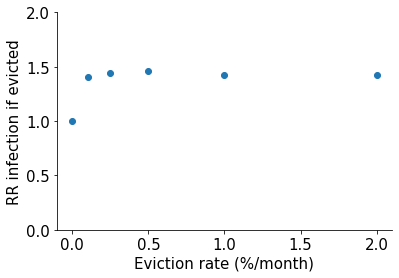

In [14]:
# Relative risk of infection for ppl in merged households
RRinf=probInfMerg/probInfNoMerg
plt.plot(evictRate,RRinf,'o')
plt.xlabel("Eviction rate (%/month)")
plt.ylabel("RR infection if evicted")
plt.ylim([0,2.0])
plt.show()


# Strong lockdown + comeback + second lockdown

In [45]:
# import files of interest

thisFolder = "lock90relax75lock90" #folder to save things in

# import baseline case
thisFile="baseline"

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_soln.pickle'
file = open(dataFile, 'rb')
soln = pickle.load(file)
file.close()

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_soln_cum.pickle'
file = open(dataFile, 'rb')
soln_cum = pickle.load(file)
file.close()

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_tvec.pickle'
file = open(dataFile, 'rb')
tvec = pickle.load(file)
file.close()

#import eviction case

thisFile=thisFileEvict

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_soln.pickle'
file = open(dataFile, 'rb')
soln_evict = pickle.load(file)
file.close()

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_soln_cum.pickle'
file = open(dataFile, 'rb')
soln_cum_evict = pickle.load(file)
file.close()

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_tvec.pickle'
file = open(dataFile, 'rb')
tvec_evict = pickle.load(file)
file.close()

#import the summary table

dataFile=mainDirectory + 'results/'+thisFolder+'/finalsize.csv'
finalsize = np.genfromtxt(dataFile, delimiter=',',skip_header=0)

In [46]:
dataFile=mainDirectory + 'results/'+thisFolder+'/finalsize.csv'
finalsize = np.genfromtxt(dataFile, delimiter=',',skip_header=1)

fileHeader=np.array(['evictRate','FinalSizeMed','FinalSizeL','FinalSizeU','delFinalSizeMed','delFinalSizeL','delFinalSizeU','fcFinalSizeMed','fcFinalSizeL','fcFinalSizeU','numDiffFinalSize','delFinalSizeP','probInfNoMerg','probInfMerg'])
evictRate=finalsize[:,0]
FinalSizeMed=finalsize[:,1]
FinalSizeL=finalsize[:,2]
FinalSizeU=finalsize[:,3]
delFinalSizeMed=finalsize[:,4]
delFinalSizeL=finalsize[:,5]
delFinalSizeU=finalsize[:,6]
fcFinalSizeMed=finalsize[:,7]
fcFinalSizeL=finalsize[:,8]
fcFinalSizeU=finalsize[:,9]
numDiffFinalSize=finalsize[:,10]
delFinalSizeP=finalsize[:,11]
probInfNoMerg=finalsize[:,12]
probInfMerg=finalsize[:,13]


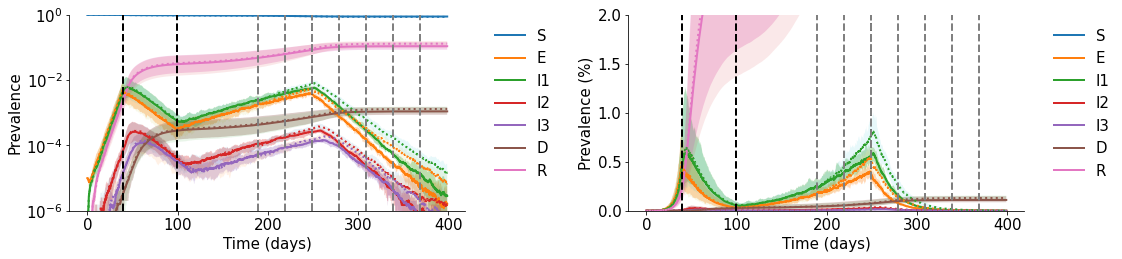

In [52]:
# Plot average trajectory with and without evictions
pop=1e6
ymax=1
scale=1
intOn=1
Tint=39
relax=1
Trelax=Tint+60
lock2=1
Tlock2=Trelax+5*30

evict=1
number_merges = 6
T_start_merge = 90 # time after last intervention that mergers start (days)
T_int_merge = 30 # interval between merges (days)
T_merge_vec=Trelax+np.arange(T_start_merge,T_start_merge*(number_merges+1),T_int_merge)

loCI=5
upCI=95

soln_avg=np.average(soln,axis=0)
soln_loCI=np.percentile(soln,loCI,axis=0)
soln_upCI=np.percentile(soln,upCI,axis=0)

soln_evict_avg=np.average(soln_evict,axis=0)
soln_evict_loCI=np.percentile(soln_evict,loCI,axis=0)
soln_evict_upCI=np.percentile(soln_evict,upCI,axis=0)

# log scale

plt.figure(figsize=(2.5*6.4, 4.0))
plt.subplot(121)

# add averages
plt.plot(tvec,soln_avg*scale)
plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
for i in range(0,7):
  plt.fill_between(tvec,soln_loCI[:,i]*scale,soln_upCI[:,i]*scale,alpha=0.3)

# add post eviction on top
plt.plot(tvec,soln_evict_avg*scale,':')
for i in range(0,7):
  plt.fill_between(tvec,soln_evict_loCI[:,i]*scale,soln_evict_upCI[:,i]*scale,alpha=0.1)

if intOn==1:
  plt.plot([Tint,Tint],[scale/pop,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[scale/pop,ymax*scale],'k--')

if lock2==1:
  plt.plot([Tlock2,Tlock2],[scale/pop,ymax*scale],'k--')

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[scale/pop,ymax*scale],'--',color='gray')

plt.ylim([scale/pop,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Prevalence")
plt.semilogy()

plt.subplot(122)
scale=100
ymax=0.02
ymin=0
plt.plot(tvec,soln_avg*scale)
plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
for i in range(0,7):
  plt.fill_between(tvec,soln_loCI[:,i]*scale,soln_upCI[:,i]*scale,alpha=0.3)


# add post eviction on top
plt.plot(tvec,soln_evict_avg*scale,':')
for i in range(0,7):
  plt.fill_between(tvec,soln_evict_loCI[:,i]*scale,soln_evict_upCI[:,i]*scale,alpha=0.1)


if intOn==1:
  plt.plot([Tint,Tint],[ymin,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[ymin,ymax*scale],'k--')

if lock2==1:
  plt.plot([Tlock2,Tlock2],[ymin,ymax*scale],'k--')

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[ymin,ymax*scale],'--',color='gray')

plt.ylim([ymin,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Prevalence (%)")


plt.tight_layout()

# if plotThis==True:
#   plt.savefig(plotName+'.pdf',bbox_inches='tight')

plt.show()

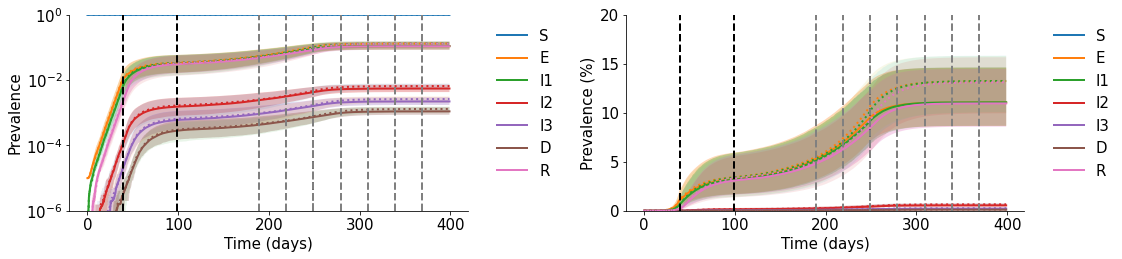

In [57]:
# For cumulative
# Plot average trajectory with and without evictions
pop=1e6
ymax=1
scale=1
intOn=1
Tint=39
relax=1
Trelax=Tint+60
lock2=1
Tlock2=Trelax+5*30

evict=1
number_merges = 6
T_start_merge = 90 # time after last intervention that mergers start (days)
T_int_merge = 30 # interval between merges (days)
T_merge_vec=Trelax+np.arange(T_start_merge,T_start_merge*(number_merges+1),T_int_merge)

loCI=5
upCI=95

soln_cum_avg=np.average(soln_cum,axis=0)
soln_cum_loCI=np.percentile(soln_cum,loCI,axis=0)
soln_cum_upCI=np.percentile(soln_cum,upCI,axis=0)

soln_cum_evict_avg=np.average(soln_cum_evict,axis=0)
soln_cum_evict_loCI=np.percentile(soln_cum_evict,loCI,axis=0)
soln_cum_evict_upCI=np.percentile(soln_cum_evict,upCI,axis=0)

# log scale

plt.figure(figsize=(2.5*6.4, 4.0))
plt.subplot(121)

# add averages
plt.plot(tvec,soln_cum_avg*scale)
plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
for i in range(0,7):
  plt.fill_between(tvec,soln_cum_loCI[:,i]*scale,soln_cum_upCI[:,i]*scale,alpha=0.3)

# add post eviction on top
plt.plot(tvec,soln_cum_evict_avg*scale,':')
for i in range(0,7):
  plt.fill_between(tvec,soln_cum_evict_loCI[:,i]*scale,soln_cum_evict_upCI[:,i]*scale,alpha=0.1)

if intOn==1:
  plt.plot([Tint,Tint],[scale/pop,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[scale/pop,ymax*scale],'k--')

if lock2==1:
  plt.plot([Tlock2,Tlock2],[scale/pop,ymax*scale],'k--')

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[scale/pop,ymax*scale],'--',color='gray')

plt.ylim([scale/pop,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Prevalence")
plt.semilogy()

plt.subplot(122)
scale=100
ymax=0.2
ymin=0
plt.plot(tvec,soln_cum_avg*scale)
plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
for i in range(0,7):
  plt.fill_between(tvec,soln_cum_loCI[:,i]*scale,soln_cum_upCI[:,i]*scale,alpha=0.3)


# add post eviction on top
plt.plot(tvec,soln_cum_evict_avg*scale,':')
for i in range(0,7):
  plt.fill_between(tvec,soln_cum_evict_loCI[:,i]*scale,soln_cum_evict_upCI[:,i]*scale,alpha=0.1)


if intOn==1:
  plt.plot([Tint,Tint],[ymin,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[ymin,ymax*scale],'k--')

if lock2==1:
  plt.plot([Tlock2,Tlock2],[ymin,ymax*scale],'k--')

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[ymin,ymax*scale],'--',color='gray')

plt.ylim([ymin,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Prevalence (%)")


plt.tight_layout()

# if plotThis==True:
#   plt.savefig(plotName+'.pdf',bbox_inches='tight')

plt.show()

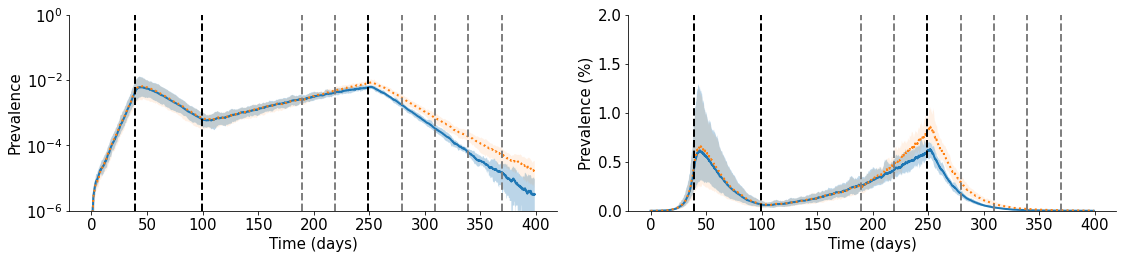

In [48]:
# same but for total infected only 

# Plot average trajectory with and without evictions
pop=1e6
ymax=1
scale=1
intOn=1
Tint=39
relax=1
Trelax=Tint+60
lock2=1
Tlock2=Trelax+5*30

evict=1
number_merges = 6
T_start_merge = 90 # time after last intervention that mergers start (days)
T_int_merge = 30 # interval between merges (days)
T_merge_vec=Trelax+np.arange(T_start_merge,T_start_merge*(number_merges+1),T_int_merge)

loCI=5
upCI=95

soln_avg=np.average(soln,axis=0)
soln_loCI=np.percentile(soln,loCI,axis=0)
soln_upCI=np.percentile(soln,upCI,axis=0)

soln_evict_avg=np.average(soln_evict,axis=0)
soln_evict_loCI=np.percentile(soln_evict,loCI,axis=0)
soln_evict_upCI=np.percentile(soln_evict,upCI,axis=0)

# log scale

plt.figure(figsize=(2.5*6.4, 4.0))
plt.subplot(121)

# add averages
plt.plot(tvec,np.sum(soln_avg[:,2:5],axis=1)*scale)
plt.plot(tvec,np.sum(soln_evict_avg[:,2:5],axis=1)*scale,':')
#plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
#for i in range(0,7):
plt.fill_between(tvec,np.sum(soln_loCI[:,2:5],axis=1)*scale,np.sum(soln_upCI[:,2:5],axis=1)*scale,alpha=0.3)
plt.fill_between(tvec,np.sum(soln_evict_loCI[:,2:5],axis=1)*scale,np.sum(soln_evict_upCI[:,2:5],axis=1)*scale,alpha=0.1)

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[scale/pop,ymax*scale],'--',color='gray')


if intOn==1:
  plt.plot([Tint,Tint],[scale/pop,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[scale/pop,ymax*scale],'k--')

if lock2==1:
  plt.plot([Tlock2,Tlock2],[scale/pop,ymax*scale],'k--')


plt.ylim([scale/pop,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Prevalence")
plt.semilogy()

plt.subplot(122)
scale=100
ymax=0.02
ymin=0
plt.plot(tvec,np.sum(soln_avg[:,2:5],axis=1)*scale)
plt.plot(tvec,np.sum(soln_evict_avg[:,2:5],axis=1)*scale,':') # add post eviction on top

#plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
plt.fill_between(tvec,np.sum(soln_loCI[:,2:5],axis=1)*scale,np.sum(soln_upCI[:,2:5],axis=1)*scale,alpha=0.3)
plt.fill_between(tvec,np.sum(soln_evict_loCI[:,2:5],axis=1)*scale,np.sum(soln_evict_upCI[:,2:5],axis=1)*scale,alpha=0.1)

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[ymin,ymax*scale],'--',color='gray')

if intOn==1:
  plt.plot([Tint,Tint],[ymin,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[ymin,ymax*scale],'k--')

if lock2==1:
  plt.plot([Tlock2,Tlock2],[ymin,ymax*scale],'k--')


plt.ylim([ymin,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Prevalence (%)")

plt.tight_layout()

plt.show()

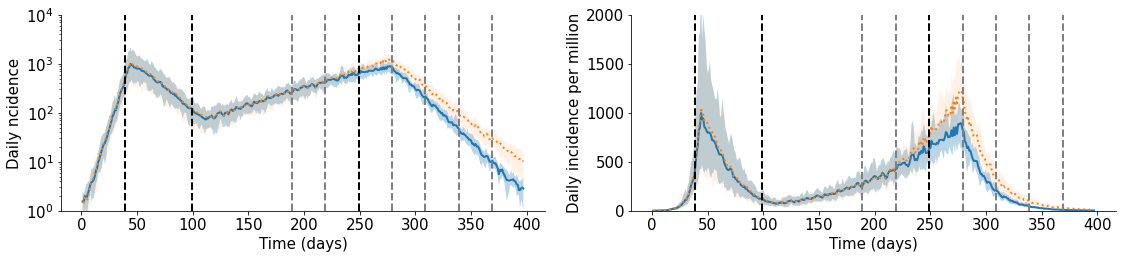

In [49]:
# Plot smoothed incidence


soln_inc=get_daily_iter(soln_cum,tvec)
soln_inc_smooth = smooth_timecourse(soln_inc,3)

soln_inc_evict=get_daily_iter(soln_cum_evict,tvec)
soln_inc_evict_smooth = smooth_timecourse(soln_inc_evict,3)

tvec2=np.arange(1,np.shape(soln_inc)[1]+1)


# same but for total infected only 

# Plot average trajectory with and without evictions
pop=1e6
ymax=0.01
scale=pop
intOn=1
Tint=39
relax=1
Trelax=Tint+60

evict=1
number_merges = 6
T_start_merge = 90 # time after last intervention that mergers start (days)
T_int_merge = 30 # interval between merges (days)
T_merge_vec=Trelax+np.arange(T_start_merge,T_start_merge*(number_merges+1),T_int_merge)

loCI=5
upCI=95

soln_avg=np.average(soln_inc_smooth,axis=0)
soln_loCI=np.percentile(soln_inc_smooth,loCI,axis=0)
soln_upCI=np.percentile(soln_inc_smooth,upCI,axis=0)

soln_evict_avg=np.average(soln_inc_evict_smooth,axis=0)
soln_evict_loCI=np.percentile(soln_inc_evict_smooth,loCI,axis=0)
soln_evict_upCI=np.percentile(soln_inc_evict_smooth,upCI,axis=0)

# log scale

plt.figure(figsize=(2.5*6.4, 4.0))
plt.subplot(121)

# add averages
plt.plot(tvec2,soln_avg[:,2]*scale)
plt.plot(tvec2,soln_evict_avg[:,2]*scale,':')
#plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
#for i in range(0,7):
plt.fill_between(tvec2,soln_loCI[:,2]*scale,soln_upCI[:,2]*scale,alpha=0.3)
plt.fill_between(tvec2,soln_evict_loCI[:,2]*scale,soln_evict_upCI[:,2]*scale,alpha=0.1)

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[scale/pop,ymax*scale],'--',color='gray')

if intOn==1:
  plt.plot([Tint,Tint],[scale/pop,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[scale/pop,ymax*scale],'k--')

if lock2==1:
  plt.plot([Tlock2,Tlock2],[scale/pop,ymax*scale],'k--')


plt.ylim([scale/pop,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Daily ncidence")
plt.semilogy()

plt.subplot(122)
scale=pop
ymax=0.002
ymin=0
plt.plot(tvec2,soln_avg[:,2]*scale)
plt.plot(tvec2,soln_evict_avg[:,2]*scale,':') # add post eviction on top

#plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
plt.fill_between(tvec2,soln_loCI[:,2]*scale,soln_upCI[:,2]*scale,alpha=0.3)
plt.fill_between(tvec2,soln_evict_loCI[:,2]*scale,soln_evict_upCI[:,2]*scale,alpha=0.1)

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[ymin,ymax*scale],'--',color='gray')

if intOn==1:
  plt.plot([Tint,Tint],[ymin,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[ymin,ymax*scale],'k--')

if lock2==1:
  plt.plot([Tlock2,Tlock2],[ymin,ymax*scale],'k--')


plt.ylim([ymin,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Daily incidence per million")

plt.tight_layout()

plt.show()


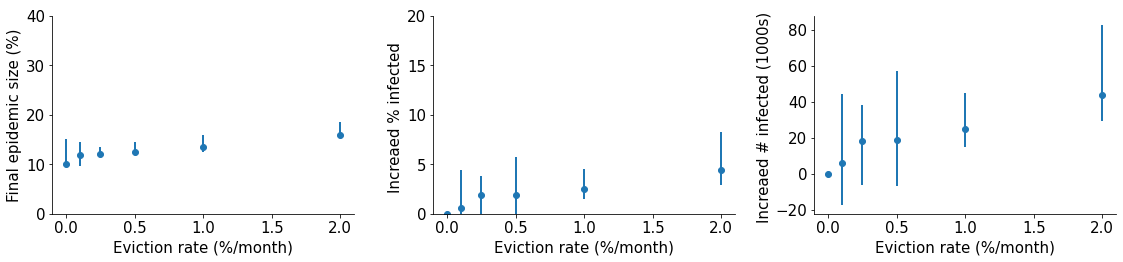

In [50]:
# Final epidemic size

plt.figure(figsize=(2.5*6.4, 4.0))

plt.subplot(131)
FinalSizeRange=[FinalSizeMed-FinalSizeL, FinalSizeU-FinalSizeMed]
plt.errorbar(evictRate,FinalSizeMed,yerr=FinalSizeRange,fmt='o')
plt.xlabel("Eviction rate (%/month)")
plt.ylabel("Final epidemic size (%)")
plt.ylim([0,40])

plt.subplot(132)
delFinalSizeRange=[delFinalSizeMed-delFinalSizeL, delFinalSizeU-delFinalSizeMed]
plt.errorbar(evictRate,delFinalSizeMed,yerr=delFinalSizeRange,fmt='o')
plt.xlabel("Eviction rate (%/month)")
plt.ylabel("Increaed % infected ")
plt.ylim([0,20])

plt.subplot(133)
delFinalSizeRange=[(pop/1e5)*(delFinalSizeMed-delFinalSizeL), (pop/1e5)*(delFinalSizeU-delFinalSizeMed)]
plt.errorbar(evictRate,(pop/1e5)*delFinalSizeMed,yerr=delFinalSizeRange,fmt='o')
plt.xlabel("Eviction rate (%/month)")
plt.ylabel("Increaed # infected (1000s) ")

plt.tight_layout()

plt.show()

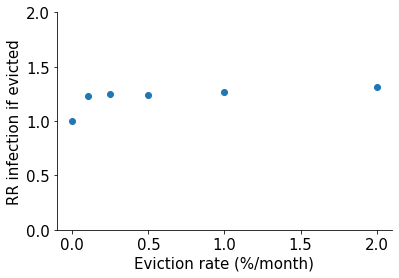

In [51]:
# Relative risk of infection for ppl in merged households
RRinf=probInfMerg/probInfNoMerg
plt.plot(evictRate,RRinf,'o')
plt.xlabel("Eviction rate (%/month)")
plt.ylabel("RR infection if evicted")
plt.ylim([0,2.0])
plt.show()


# Strong lockdown + plateau

In [22]:
# import files of interest

thisFolder = "lock90relax80" #folder to save things in

# import baseline case
thisFile="baseline"

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_soln.pickle'
file = open(dataFile, 'rb')
soln = pickle.load(file)
file.close()

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_soln_cum.pickle'
file = open(dataFile, 'rb')
soln_cum = pickle.load(file)
file.close()

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_tvec.pickle'
file = open(dataFile, 'rb')
tvec = pickle.load(file)
file.close()

#import eviction case

thisFile=thisFileEvict

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_soln.pickle'
file = open(dataFile, 'rb')
soln_evict = pickle.load(file)
file.close()

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_soln_cum.pickle'
file = open(dataFile, 'rb')
soln_cum_evict = pickle.load(file)
file.close()

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_tvec.pickle'
file = open(dataFile, 'rb')
tvec_evict = pickle.load(file)
file.close()

#import the summary table

dataFile=mainDirectory + 'results/'+thisFolder+'/finalsize.csv'
finalsize = np.genfromtxt(dataFile, delimiter=',',skip_header=0)

In [23]:
dataFile=mainDirectory + 'results/'+thisFolder+'/finalsize.csv'
finalsize = np.genfromtxt(dataFile, delimiter=',',skip_header=1)

fileHeader=np.array(['evictRate','FinalSizeMed','FinalSizeL','FinalSizeU','delFinalSizeMed','delFinalSizeL','delFinalSizeU','fcFinalSizeMed','fcFinalSizeL','fcFinalSizeU','numDiffFinalSize','delFinalSizeP','probInfNoMerg','probInfMerg'])
evictRate=finalsize[:,0]
FinalSizeMed=finalsize[:,1]
FinalSizeL=finalsize[:,2]
FinalSizeU=finalsize[:,3]
delFinalSizeMed=finalsize[:,4]
delFinalSizeL=finalsize[:,5]
delFinalSizeU=finalsize[:,6]
fcFinalSizeMed=finalsize[:,7]
fcFinalSizeL=finalsize[:,8]
fcFinalSizeU=finalsize[:,9]
numDiffFinalSize=finalsize[:,10]
delFinalSizeP=finalsize[:,11]
probInfNoMerg=finalsize[:,12]
probInfMerg=finalsize[:,13]


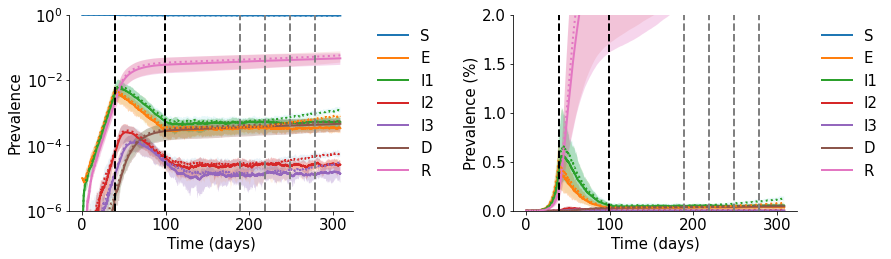

In [24]:
# Plot average trajectory with and without evictions
pop=1e6
ymax=1
scale=1
intOn=1
Tint=39
relax=1
Trelax=Tint+60

evict=1
number_merges = 3
T_start_merge = 90 # time after last intervention that mergers start (days)
T_int_merge = 30 # interval between merges (days)
T_merge_vec=Trelax+np.arange(T_start_merge,T_start_merge*(number_merges+1),T_int_merge)

loCI=5
upCI=95

soln_avg=np.average(soln,axis=0)
soln_loCI=np.percentile(soln,loCI,axis=0)
soln_upCI=np.percentile(soln,upCI,axis=0)

soln_evict_avg=np.average(soln_evict,axis=0)
soln_evict_loCI=np.percentile(soln_evict,loCI,axis=0)
soln_evict_upCI=np.percentile(soln_evict,upCI,axis=0)

# log scale

plt.figure(figsize=(2*6.4, 4.0))
plt.subplot(121)

# add averages
plt.plot(tvec,soln_avg*scale)
plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
for i in range(0,7):
  plt.fill_between(tvec,soln_loCI[:,i]*scale,soln_upCI[:,i]*scale,alpha=0.3)

# add post eviction on top
plt.plot(tvec,soln_evict_avg*scale,':')
for i in range(0,7):
  plt.fill_between(tvec,soln_evict_loCI[:,i]*scale,soln_evict_upCI[:,i]*scale,alpha=0.1)

if intOn==1:
  plt.plot([Tint,Tint],[scale/pop,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[scale/pop,ymax*scale],'k--')

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[scale/pop,ymax*scale],'--',color='gray')

plt.ylim([scale/pop,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Prevalence")
plt.semilogy()

plt.subplot(122)
scale=100
ymax=0.02
ymin=0
plt.plot(tvec,soln_avg*scale)
plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
for i in range(0,7):
  plt.fill_between(tvec,soln_loCI[:,i]*scale,soln_upCI[:,i]*scale,alpha=0.3)

# add post eviction on top
plt.plot(tvec,soln_evict_avg*scale,':')
for i in range(0,7):
  plt.fill_between(tvec,soln_evict_loCI[:,i]*scale,soln_evict_upCI[:,i]*scale,alpha=0.1)


if intOn==1:
  plt.plot([Tint,Tint],[ymin,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[ymin,ymax*scale],'k--')

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[ymin,ymax*scale],'--',color='gray')

plt.ylim([ymin,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Prevalence (%)")


plt.tight_layout()

# if plotThis==True:
#   plt.savefig(plotName+'.pdf',bbox_inches='tight')

plt.show()

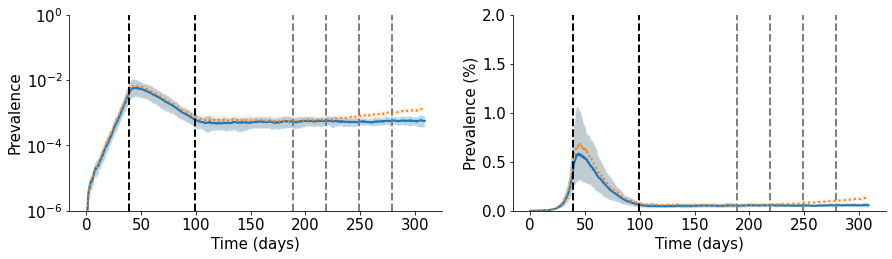

In [25]:
# same but for total infected only 

# Plot average trajectory with and without evictions
pop=1e6
ymax=1
scale=1
intOn=1
Tint=39
relax=1
Trelax=Tint+60

evict=1
number_merges = 3
T_start_merge = 90 # time after last intervention that mergers start (days)
T_int_merge = 30 # interval between merges (days)
T_merge_vec=Trelax+np.arange(T_start_merge,T_start_merge*(number_merges+1),T_int_merge)

loCI=5
upCI=95

soln_avg=np.average(soln,axis=0)
soln_loCI=np.percentile(soln,loCI,axis=0)
soln_upCI=np.percentile(soln,upCI,axis=0)

soln_evict_avg=np.average(soln_evict,axis=0)
soln_evict_loCI=np.percentile(soln_evict,loCI,axis=0)
soln_evict_upCI=np.percentile(soln_evict,upCI,axis=0)

# log scale

plt.figure(figsize=(2*6.4, 4.0))
plt.subplot(121)

# add averages
plt.plot(tvec,np.sum(soln_avg[:,2:5],axis=1)*scale)
plt.plot(tvec,np.sum(soln_evict_avg[:,2:5],axis=1)*scale,':')
#plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
#for i in range(0,7):
plt.fill_between(tvec,np.sum(soln_loCI[:,2:5],axis=1)*scale,np.sum(soln_upCI[:,2:5],axis=1)*scale,alpha=0.3)
plt.fill_between(tvec,np.sum(soln_evict_loCI[:,2:5],axis=1)*scale,np.sum(soln_evict_upCI[:,2:5],axis=1)*scale,alpha=0.1)

if intOn==1:
  plt.plot([Tint,Tint],[scale/pop,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[scale/pop,ymax*scale],'k--')

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[scale/pop,ymax*scale],'--',color='gray')

plt.ylim([scale/pop,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Prevalence")
plt.semilogy()

plt.subplot(122)
scale=100
ymax=0.02
ymin=0
plt.plot(tvec,np.sum(soln_avg[:,2:5],axis=1)*scale)
plt.plot(tvec,np.sum(soln_evict_avg[:,2:5],axis=1)*scale,':') # add post eviction on top

#plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
plt.fill_between(tvec,np.sum(soln_loCI[:,2:5],axis=1)*scale,np.sum(soln_upCI[:,2:5],axis=1)*scale,alpha=0.3)
plt.fill_between(tvec,np.sum(soln_evict_loCI[:,2:5],axis=1)*scale,np.sum(soln_evict_upCI[:,2:5],axis=1)*scale,alpha=0.1)

if intOn==1:
  plt.plot([Tint,Tint],[ymin,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[ymin,ymax*scale],'k--')

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[ymin,ymax*scale],'--',color='gray')

plt.ylim([ymin,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Prevalence (%)")

plt.tight_layout()

plt.show()

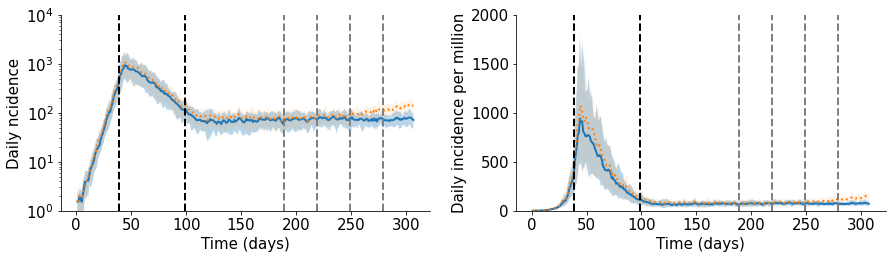

In [26]:
# Plot smoothed incidence

soln_inc=get_daily_iter(soln_cum,tvec)
soln_inc_smooth = smooth_timecourse(soln_inc,3)

soln_inc_evict=get_daily_iter(soln_cum_evict,tvec)
soln_inc_evict_smooth = smooth_timecourse(soln_inc_evict,3)

tvec2=np.arange(1,np.shape(soln_inc)[1]+1)

# same but for total infected only 

# Plot average trajectory with and without evictions
pop=1e6
ymax=0.01
scale=pop
intOn=1
Tint=39
relax=1
Trelax=Tint+60

evict=1
number_merges = 3
T_start_merge = 90 # time after last intervention that mergers start (days)
T_int_merge = 30 # interval between merges (days)
T_merge_vec=Trelax+np.arange(T_start_merge,T_start_merge*(number_merges+1),T_int_merge)

loCI=5
upCI=95

soln_avg=np.average(soln_inc_smooth,axis=0)
soln_loCI=np.percentile(soln_inc_smooth,loCI,axis=0)
soln_upCI=np.percentile(soln_inc_smooth,upCI,axis=0)

soln_evict_avg=np.average(soln_inc_evict_smooth,axis=0)
soln_evict_loCI=np.percentile(soln_inc_evict_smooth,loCI,axis=0)
soln_evict_upCI=np.percentile(soln_inc_evict_smooth,upCI,axis=0)

# log scale

plt.figure(figsize=(2*6.4, 4.0))
plt.subplot(121)

# add averages
plt.plot(tvec2,soln_avg[:,2]*scale)
plt.plot(tvec2,soln_evict_avg[:,2]*scale,':')
#plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
#for i in range(0,7):
plt.fill_between(tvec2,soln_loCI[:,2]*scale,soln_upCI[:,2]*scale,alpha=0.3)
plt.fill_between(tvec2,soln_evict_loCI[:,2]*scale,soln_evict_upCI[:,2]*scale,alpha=0.1)

if intOn==1:
  plt.plot([Tint,Tint],[scale/pop,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[scale/pop,ymax*scale],'k--')

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[scale/pop,ymax*scale],'--',color='gray')

plt.ylim([scale/pop,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Daily ncidence")
plt.semilogy()

plt.subplot(122)
scale=pop
ymax=0.002
ymin=0
plt.plot(tvec2,soln_avg[:,2]*scale)
plt.plot(tvec2,soln_evict_avg[:,2]*scale,':') # add post eviction on top

#plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
plt.fill_between(tvec2,soln_loCI[:,2]*scale,soln_upCI[:,2]*scale,alpha=0.3)
plt.fill_between(tvec2,soln_evict_loCI[:,2]*scale,soln_evict_upCI[:,2]*scale,alpha=0.1)

if intOn==1:
  plt.plot([Tint,Tint],[ymin,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[ymin,ymax*scale],'k--')

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[ymin,ymax*scale],'--',color='gray')

plt.ylim([ymin,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Daily incidence per million")

plt.tight_layout()

plt.show()


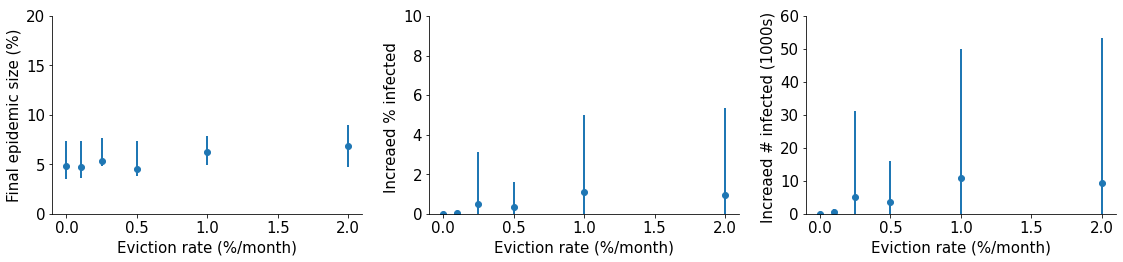

In [27]:
# Final epidemic size

plt.figure(figsize=(2.5*6.4, 4.0))

plt.subplot(131)
FinalSizeRange=[FinalSizeMed-FinalSizeL, FinalSizeU-FinalSizeMed]
plt.errorbar(evictRate,FinalSizeMed,yerr=FinalSizeRange,fmt='o')
plt.xlabel("Eviction rate (%/month)")
plt.ylabel("Final epidemic size (%)")
plt.ylim([0,20])

plt.subplot(132)
delFinalSizeRange=[delFinalSizeMed-delFinalSizeL, delFinalSizeU-delFinalSizeMed]
plt.errorbar(evictRate,delFinalSizeMed,yerr=delFinalSizeRange,fmt='o')
plt.xlabel("Eviction rate (%/month)")
plt.ylabel("Increaed % infected ")
plt.ylim([0,10])

plt.subplot(133)
delFinalSizeRange=[(pop/1e5)*(delFinalSizeMed-delFinalSizeL), (pop/1e5)*(delFinalSizeU-delFinalSizeMed)]
plt.errorbar(evictRate,(pop/1e5)*delFinalSizeMed,yerr=delFinalSizeRange,fmt='o')
plt.xlabel("Eviction rate (%/month)")
plt.ylabel("Increaed # infected (1000s) ")
plt.ylim([0,60])

plt.tight_layout()

plt.show()

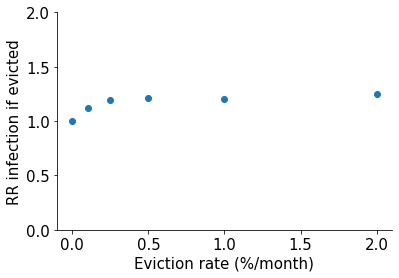

In [28]:
# Relative risk of infection for ppl in merged households
RRinf=probInfMerg/probInfNoMerg
plt.plot(evictRate,RRinf,'o')
plt.xlabel("Eviction rate (%/month)")
plt.ylabel("RR infection if evicted")
plt.ylim([0,2.0])
plt.show()


# Weak lockdown + comeback

In [29]:
# import files of interest

thisFolder = "lock80relax75" #folder to save things in

# import baseline case
thisFile="baseline"

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_soln.pickle'
file = open(dataFile, 'rb')
soln = pickle.load(file)
file.close()

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_soln_cum.pickle'
file = open(dataFile, 'rb')
soln_cum = pickle.load(file)
file.close()

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_tvec.pickle'
file = open(dataFile, 'rb')
tvec = pickle.load(file)
file.close()

#import eviction case

thisFile=thisFileEvict

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_soln.pickle'
file = open(dataFile, 'rb')
soln_evict = pickle.load(file)
file.close()

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_soln_cum.pickle'
file = open(dataFile, 'rb')
soln_cum_evict = pickle.load(file)
file.close()

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_tvec.pickle'
file = open(dataFile, 'rb')
tvec_evict = pickle.load(file)
file.close()

#import the summary table

dataFile=mainDirectory + 'results/'+thisFolder+'/finalsize.csv'
finalsize = np.genfromtxt(dataFile, delimiter=',',skip_header=0)

In [30]:
dataFile=mainDirectory + 'results/'+thisFolder+'/finalsize.csv'
finalsize = np.genfromtxt(dataFile, delimiter=',',skip_header=1)

fileHeader=np.array(['evictRate','FinalSizeMed','FinalSizeL','FinalSizeU','delFinalSizeMed','delFinalSizeL','delFinalSizeU','fcFinalSizeMed','fcFinalSizeL','fcFinalSizeU','numDiffFinalSize','delFinalSizeP','probInfNoMerg','probInfMerg'])
evictRate=finalsize[:,0]
FinalSizeMed=finalsize[:,1]
FinalSizeL=finalsize[:,2]
FinalSizeU=finalsize[:,3]
delFinalSizeMed=finalsize[:,4]
delFinalSizeL=finalsize[:,5]
delFinalSizeU=finalsize[:,6]
fcFinalSizeMed=finalsize[:,7]
fcFinalSizeL=finalsize[:,8]
fcFinalSizeU=finalsize[:,9]
numDiffFinalSize=finalsize[:,10]
delFinalSizeP=finalsize[:,11]
probInfNoMerg=finalsize[:,12]
probInfMerg=finalsize[:,13]


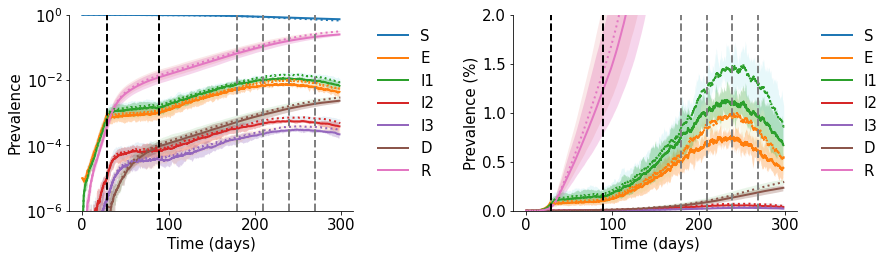

In [31]:
# Plot average trajectory with and without evictions
pop=1e6
ymax=1
scale=1
intOn=1
Tint=29
relax=1
Trelax=Tint+60

evict=1
number_merges = 3
T_start_merge = 90 # time after last intervention that mergers start (days)
T_int_merge = 30 # interval between merges (days)
T_merge_vec=Trelax+np.arange(T_start_merge,T_start_merge*(number_merges+1),T_int_merge)

loCI=5
upCI=95

soln_avg=np.average(soln,axis=0)
soln_loCI=np.percentile(soln,loCI,axis=0)
soln_upCI=np.percentile(soln,upCI,axis=0)

soln_evict_avg=np.average(soln_evict,axis=0)
soln_evict_loCI=np.percentile(soln_evict,loCI,axis=0)
soln_evict_upCI=np.percentile(soln_evict,upCI,axis=0)

# log scale

plt.figure(figsize=(2*6.4, 4.0))
plt.subplot(121)

# add averages
plt.plot(tvec,soln_avg*scale)
plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
for i in range(0,7):
  plt.fill_between(tvec,soln_loCI[:,i]*scale,soln_upCI[:,i]*scale,alpha=0.3)

# add post eviction on top
plt.plot(tvec_evict,soln_evict_avg*scale,':')
for i in range(0,7):
  plt.fill_between(tvec_evict,soln_evict_loCI[:,i]*scale,soln_evict_upCI[:,i]*scale,alpha=0.1)

if intOn==1:
  plt.plot([Tint,Tint],[scale/pop,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[scale/pop,ymax*scale],'k--')

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[scale/pop,ymax*scale],'--',color='gray')

plt.ylim([scale/pop,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Prevalence")
plt.semilogy()

plt.subplot(122)
scale=100
ymax=0.02
ymin=0
plt.plot(tvec,soln_avg*scale)
plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
for i in range(0,7):
  plt.fill_between(tvec,soln_loCI[:,i]*scale,soln_upCI[:,i]*scale,alpha=0.3)

# add post eviction on top
plt.plot(tvec_evict,soln_evict_avg*scale,':')
for i in range(0,7):
  plt.fill_between(tvec_evict,soln_evict_loCI[:,i]*scale,soln_evict_upCI[:,i]*scale,alpha=0.1)


if intOn==1:
  plt.plot([Tint,Tint],[ymin,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[ymin,ymax*scale],'k--')

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[ymin,ymax*scale],'--',color='gray')

plt.ylim([ymin,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Prevalence (%)")


plt.tight_layout()

# if plotThis==True:
#   plt.savefig(plotName+'.pdf',bbox_inches='tight')

plt.show()

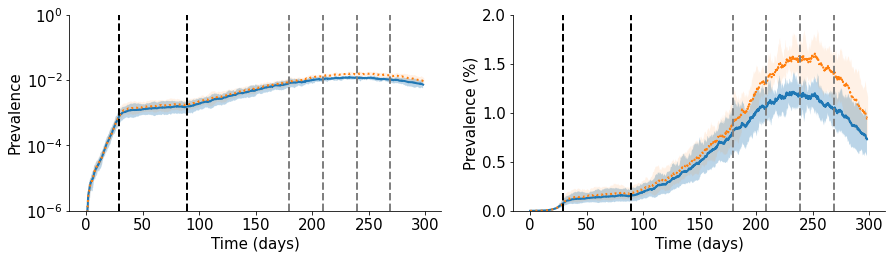

In [32]:
# same but for total infected only 

# Plot average trajectory with and without evictions
pop=1e6
ymax=1
scale=1
intOn=1
Tint=29
relax=1
Trelax=Tint+60

evict=1
number_merges = 3
T_start_merge = 90 # time after last intervention that mergers start (days)
T_int_merge = 30 # interval between merges (days)
T_merge_vec=Trelax+np.arange(T_start_merge,T_start_merge*(number_merges+1),T_int_merge)

loCI=5
upCI=95

soln_avg=np.average(soln,axis=0)
soln_loCI=np.percentile(soln,loCI,axis=0)
soln_upCI=np.percentile(soln,upCI,axis=0)

soln_evict_avg=np.average(soln_evict,axis=0)
soln_evict_loCI=np.percentile(soln_evict,loCI,axis=0)
soln_evict_upCI=np.percentile(soln_evict,upCI,axis=0)

# log scale

plt.figure(figsize=(2*6.4, 4.0))
plt.subplot(121)

# add averages
plt.plot(tvec,np.sum(soln_avg[:,2:5],axis=1)*scale)
plt.plot(tvec_evict,np.sum(soln_evict_avg[:,2:5],axis=1)*scale,':')
#plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
#for i in range(0,7):
plt.fill_between(tvec,np.sum(soln_loCI[:,2:5],axis=1)*scale,np.sum(soln_upCI[:,2:5],axis=1)*scale,alpha=0.3)
plt.fill_between(tvec_evict,np.sum(soln_evict_loCI[:,2:5],axis=1)*scale,np.sum(soln_evict_upCI[:,2:5],axis=1)*scale,alpha=0.1)

if intOn==1:
  plt.plot([Tint,Tint],[scale/pop,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[scale/pop,ymax*scale],'k--')

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[scale/pop,ymax*scale],'--',color='gray')

plt.ylim([scale/pop,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Prevalence")
plt.semilogy()

plt.subplot(122)
scale=100
ymax=0.02
ymin=0
plt.plot(tvec,np.sum(soln_avg[:,2:5],axis=1)*scale)
plt.plot(tvec_evict,np.sum(soln_evict_avg[:,2:5],axis=1)*scale,':') # add post eviction on top

#plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
plt.fill_between(tvec,np.sum(soln_loCI[:,2:5],axis=1)*scale,np.sum(soln_upCI[:,2:5],axis=1)*scale,alpha=0.3)
plt.fill_between(tvec_evict,np.sum(soln_evict_loCI[:,2:5],axis=1)*scale,np.sum(soln_evict_upCI[:,2:5],axis=1)*scale,alpha=0.1)

if intOn==1:
  plt.plot([Tint,Tint],[ymin,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[ymin,ymax*scale],'k--')

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[ymin,ymax*scale],'--',color='gray')

plt.ylim([ymin,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Prevalence (%)")

plt.tight_layout()

plt.show()

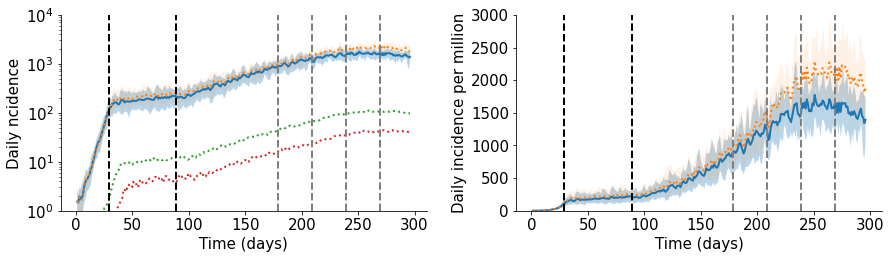

In [33]:
# Plot smoothed incidence

soln_inc=get_daily_iter(soln_cum,tvec)
soln_inc_smooth = smooth_timecourse(soln_inc,3)

soln_inc_evict=get_daily_iter(soln_cum_evict,tvec)
soln_inc_evict_smooth = smooth_timecourse(soln_inc_evict,3)

tvec2=np.arange(1,np.shape(soln_inc)[1]+1)
tvec2_evict=np.arange(1,np.shape(soln_inc_evict)[1]+1)

# same but for total infected only 

# Plot average trajectory with and without evictions
pop=1e6
ymax=0.01
scale=pop
intOn=1
Tint=29
relax=1
Trelax=Tint+60

evict=1
number_merges = 3
T_start_merge = 90 # time after last intervention that mergers start (days)
T_int_merge = 30 # interval between merges (days)
T_merge_vec=Trelax+np.arange(T_start_merge,T_start_merge*(number_merges+1),T_int_merge)

loCI=5
upCI=95

soln_avg=np.average(soln_inc_smooth,axis=0)
soln_loCI=np.percentile(soln_inc_smooth,loCI,axis=0)
soln_upCI=np.percentile(soln_inc_smooth,upCI,axis=0)

soln_evict_avg=np.average(soln_inc_evict_smooth,axis=0)
soln_evict_loCI=np.percentile(soln_inc_evict_smooth,loCI,axis=0)
soln_evict_upCI=np.percentile(soln_inc_evict_smooth,upCI,axis=0)

# log scale

plt.figure(figsize=(2*6.4, 4.0))
plt.subplot(121)

# add averages
plt.plot(tvec2,soln_avg[:,2]*scale)
plt.plot(tvec2_evict,soln_evict_avg[:,2:5]*scale,':')
#plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
#for i in range(0,7):
plt.fill_between(tvec2,soln_loCI[:,2]*scale,soln_upCI[:,2]*scale,alpha=0.3)
plt.fill_between(tvec2_evict,soln_evict_loCI[:,2]*scale,soln_evict_upCI[:,2]*scale,alpha=0.1)

if intOn==1:
  plt.plot([Tint,Tint],[scale/pop,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[scale/pop,ymax*scale],'k--')

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[scale/pop,ymax*scale],'--',color='gray')

plt.ylim([scale/pop,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Daily ncidence")
plt.semilogy()

plt.subplot(122)
scale=pop
ymax=0.003
ymin=0
plt.plot(tvec2,soln_avg[:,2]*scale)
plt.plot(tvec2_evict,soln_evict_avg[:,2]*scale,':') # add post eviction on top

#plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
plt.fill_between(tvec2,soln_loCI[:,2]*scale,soln_upCI[:,2]*scale,alpha=0.3)
plt.fill_between(tvec2_evict,soln_evict_loCI[:,2]*scale,soln_evict_upCI[:,2]*scale,alpha=0.1)

if intOn==1:
  plt.plot([Tint,Tint],[ymin,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[ymin,ymax*scale],'k--')

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[ymin,ymax*scale],'--',color='gray')

plt.ylim([ymin,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Daily incidence per million")

plt.tight_layout()

plt.show()


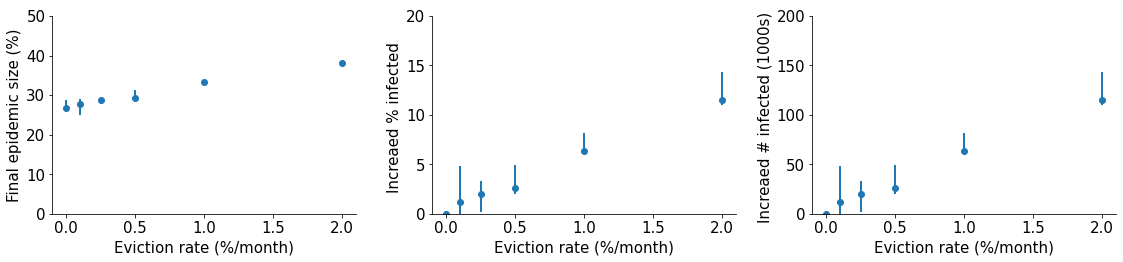

In [34]:
# Final epidemic size

plt.figure(figsize=(2.5*6.4, 4.0))

plt.subplot(131)
FinalSizeRange=[FinalSizeMed-FinalSizeL, FinalSizeU-FinalSizeMed]
plt.errorbar(evictRate,FinalSizeMed,yerr=FinalSizeRange,fmt='o')
plt.xlabel("Eviction rate (%/month)")
plt.ylabel("Final epidemic size (%)")
plt.ylim([0,50])

plt.subplot(132)
delFinalSizeRange=[delFinalSizeMed-delFinalSizeL, delFinalSizeU-delFinalSizeMed]
plt.errorbar(evictRate,delFinalSizeMed,yerr=delFinalSizeRange,fmt='o')
plt.xlabel("Eviction rate (%/month)")
plt.ylabel("Increaed % infected ")
plt.ylim([0,20])

plt.subplot(133)
delFinalSizeRange=[(pop/1e5)*(delFinalSizeMed-delFinalSizeL), (pop/1e5)*(delFinalSizeU-delFinalSizeMed)]
plt.errorbar(evictRate,(pop/1e5)*delFinalSizeMed,yerr=delFinalSizeRange,fmt='o')
plt.xlabel("Eviction rate (%/month)")
plt.ylabel("Increaed # infected (1000s) ")
plt.ylim([0,200])

plt.tight_layout()

plt.show()

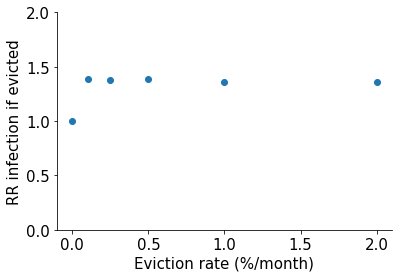

In [35]:
# Relative risk of infection for ppl in merged households
RRinf=probInfMerg/probInfNoMerg
plt.plot(evictRate,RRinf,'o')
plt.xlabel("Eviction rate (%/month)")
plt.ylabel("RR infection if evicted")
plt.ylim([0,2.0])
plt.show()


# Weak lockdown + comeback + second lockdown

In [36]:
# import files of interest

thisFolder = "lock80relax75lock90" #folder to save things in

# import baseline case
thisFile="baseline"

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_soln.pickle'
file = open(dataFile, 'rb')
soln = pickle.load(file)
file.close()

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_soln_cum.pickle'
file = open(dataFile, 'rb')
soln_cum = pickle.load(file)
file.close()

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_tvec.pickle'
file = open(dataFile, 'rb')
tvec = pickle.load(file)
file.close()

#import eviction case

thisFile=thisFileEvict

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_soln.pickle'
file = open(dataFile, 'rb')
soln_evict = pickle.load(file)
file.close()

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_soln_cum.pickle'
file = open(dataFile, 'rb')
soln_cum_evict = pickle.load(file)
file.close()

dataFile=mainDirectory + 'results/'+thisFolder+'/'+thisFile+'_tvec.pickle'
file = open(dataFile, 'rb')
tvec_evict = pickle.load(file)
file.close()

#import the summary table

dataFile=mainDirectory + 'results/'+thisFolder+'/finalsize.csv'
finalsize = np.genfromtxt(dataFile, delimiter=',',skip_header=0)

In [37]:
dataFile=mainDirectory + 'results/'+thisFolder+'/finalsize.csv'
finalsize = np.genfromtxt(dataFile, delimiter=',',skip_header=1)

fileHeader=np.array(['evictRate','FinalSizeMed','FinalSizeL','FinalSizeU','delFinalSizeMed','delFinalSizeL','delFinalSizeU','fcFinalSizeMed','fcFinalSizeL','fcFinalSizeU','numDiffFinalSize','delFinalSizeP','probInfNoMerg','probInfMerg'])
evictRate=finalsize[:,0]
FinalSizeMed=finalsize[:,1]
FinalSizeL=finalsize[:,2]
FinalSizeU=finalsize[:,3]
delFinalSizeMed=finalsize[:,4]
delFinalSizeL=finalsize[:,5]
delFinalSizeU=finalsize[:,6]
fcFinalSizeMed=finalsize[:,7]
fcFinalSizeL=finalsize[:,8]
fcFinalSizeU=finalsize[:,9]
numDiffFinalSize=finalsize[:,10]
delFinalSizeP=finalsize[:,11]
probInfNoMerg=finalsize[:,12]
probInfMerg=finalsize[:,13]


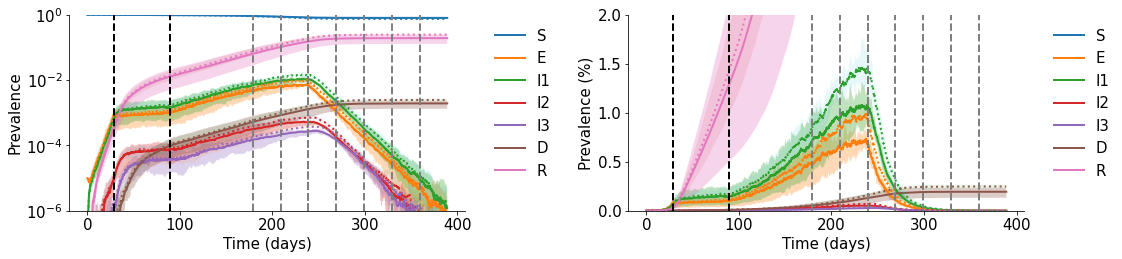

In [38]:
# Plot average trajectory with and without evictions
pop=1e6
ymax=1
scale=1
intOn=1
Tint=29
relax=1
Trelax=Tint+60
lock2=1
Tlock2=Trelax+5*30

evict=1
number_merges = 6
T_start_merge = 90 # time after last intervention that mergers start (days)
T_int_merge = 30 # interval between merges (days)
T_merge_vec=Trelax+np.arange(T_start_merge,T_start_merge*(number_merges+1),T_int_merge)

loCI=5
upCI=95

soln_avg=np.average(soln,axis=0)
soln_loCI=np.percentile(soln,loCI,axis=0)
soln_upCI=np.percentile(soln,upCI,axis=0)

soln_evict_avg=np.average(soln_evict,axis=0)
soln_evict_loCI=np.percentile(soln_evict,loCI,axis=0)
soln_evict_upCI=np.percentile(soln_evict,upCI,axis=0)

# log scale

plt.figure(figsize=(2.5*6.4, 4.0))
plt.subplot(121)

# add averages
plt.plot(tvec,soln_avg*scale)
plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
for i in range(0,7):
  plt.fill_between(tvec,soln_loCI[:,i]*scale,soln_upCI[:,i]*scale,alpha=0.3)

# add post eviction on top
plt.plot(tvec,soln_evict_avg*scale,':')
for i in range(0,7):
  plt.fill_between(tvec,soln_evict_loCI[:,i]*scale,soln_evict_upCI[:,i]*scale,alpha=0.1)

if intOn==1:
  plt.plot([Tint,Tint],[scale/pop,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[scale/pop,ymax*scale],'k--')

if lock2==1:
  plt.plot([Tlock2,Tlock2],[scale/pop,ymax*scale],'k--')

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[scale/pop,ymax*scale],'--',color='gray')

plt.ylim([scale/pop,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Prevalence")
plt.semilogy()

plt.subplot(122)
scale=100
ymax=0.02
ymin=0
plt.plot(tvec,soln_avg*scale)
plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
for i in range(0,7):
  plt.fill_between(tvec,soln_loCI[:,i]*scale,soln_upCI[:,i]*scale,alpha=0.3)


# add post eviction on top
plt.plot(tvec,soln_evict_avg*scale,':')
for i in range(0,7):
  plt.fill_between(tvec,soln_evict_loCI[:,i]*scale,soln_evict_upCI[:,i]*scale,alpha=0.1)


if intOn==1:
  plt.plot([Tint,Tint],[ymin,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[ymin,ymax*scale],'k--')

if lock2==1:
  plt.plot([Tlock2,Tlock2],[ymin,ymax*scale],'k--')

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[ymin,ymax*scale],'--',color='gray')

plt.ylim([ymin,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Prevalence (%)")


plt.tight_layout()

# if plotThis==True:
#   plt.savefig(plotName+'.pdf',bbox_inches='tight')

plt.show()

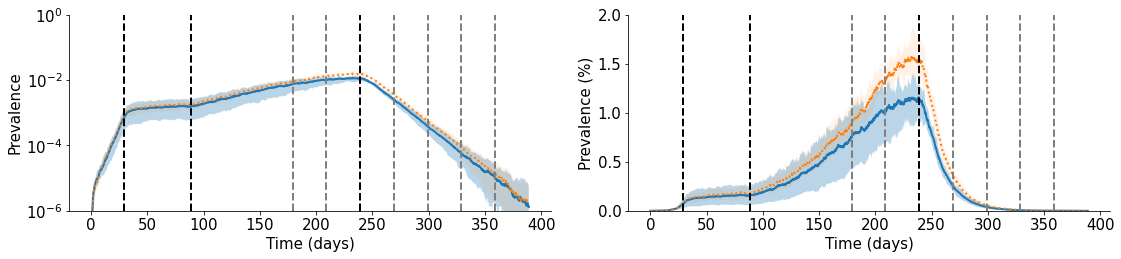

In [39]:
# same but for total infected only 

# Plot average trajectory with and without evictions
pop=1e6
ymax=1
scale=1
intOn=1
Tint=29
relax=1
Trelax=Tint+60
lock2=1
Tlock2=Trelax+5*30

evict=1
number_merges = 6
T_start_merge = 90 # time after last intervention that mergers start (days)
T_int_merge = 30 # interval between merges (days)
T_merge_vec=Trelax+np.arange(T_start_merge,T_start_merge*(number_merges+1),T_int_merge)

loCI=5
upCI=95

soln_avg=np.average(soln,axis=0)
soln_loCI=np.percentile(soln,loCI,axis=0)
soln_upCI=np.percentile(soln,upCI,axis=0)

soln_evict_avg=np.average(soln_evict,axis=0)
soln_evict_loCI=np.percentile(soln_evict,loCI,axis=0)
soln_evict_upCI=np.percentile(soln_evict,upCI,axis=0)

# log scale

plt.figure(figsize=(2.5*6.4, 4.0))
plt.subplot(121)

# add averages
plt.plot(tvec,np.sum(soln_avg[:,2:5],axis=1)*scale)
plt.plot(tvec,np.sum(soln_evict_avg[:,2:5],axis=1)*scale,':')
#plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
#for i in range(0,7):
plt.fill_between(tvec,np.sum(soln_loCI[:,2:5],axis=1)*scale,np.sum(soln_upCI[:,2:5],axis=1)*scale,alpha=0.3)
plt.fill_between(tvec,np.sum(soln_evict_loCI[:,2:5],axis=1)*scale,np.sum(soln_evict_upCI[:,2:5],axis=1)*scale,alpha=0.1)

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[scale/pop,ymax*scale],'--',color='gray')


if intOn==1:
  plt.plot([Tint,Tint],[scale/pop,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[scale/pop,ymax*scale],'k--')

if lock2==1:
  plt.plot([Tlock2,Tlock2],[scale/pop,ymax*scale],'k--')


plt.ylim([scale/pop,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Prevalence")
plt.semilogy()

plt.subplot(122)
scale=100
ymax=0.02
ymin=0
plt.plot(tvec,np.sum(soln_avg[:,2:5],axis=1)*scale)
plt.plot(tvec,np.sum(soln_evict_avg[:,2:5],axis=1)*scale,':') # add post eviction on top

#plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
plt.fill_between(tvec,np.sum(soln_loCI[:,2:5],axis=1)*scale,np.sum(soln_upCI[:,2:5],axis=1)*scale,alpha=0.3)
plt.fill_between(tvec,np.sum(soln_evict_loCI[:,2:5],axis=1)*scale,np.sum(soln_evict_upCI[:,2:5],axis=1)*scale,alpha=0.1)

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[ymin,ymax*scale],'--',color='gray')

if intOn==1:
  plt.plot([Tint,Tint],[ymin,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[ymin,ymax*scale],'k--')

if lock2==1:
  plt.plot([Tlock2,Tlock2],[ymin,ymax*scale],'k--')


plt.ylim([ymin,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Prevalence (%)")

plt.tight_layout()

plt.show()

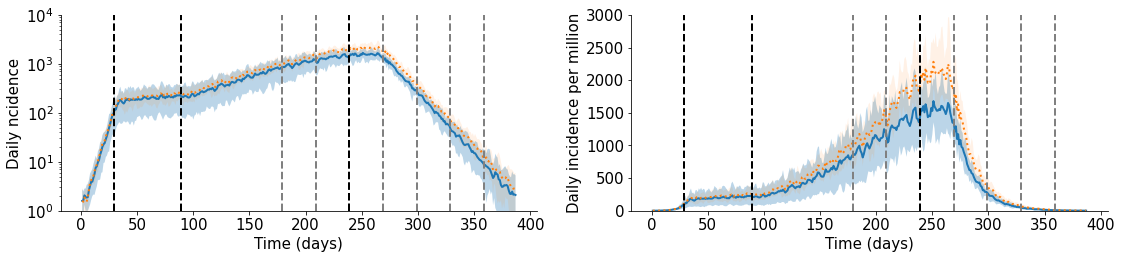

In [43]:
# Plot smoothed incidence


soln_inc=get_daily_iter(soln_cum,tvec)
soln_inc_smooth = smooth_timecourse(soln_inc,3)

soln_inc_evict=get_daily_iter(soln_cum_evict,tvec)
soln_inc_evict_smooth = smooth_timecourse(soln_inc_evict,3)

tvec2=np.arange(1,np.shape(soln_inc)[1]+1)


# same but for total infected only 

# Plot average trajectory with and without evictions
pop=1e6
ymax=0.01
scale=pop
intOn=1
Tint=29
relax=1
Trelax=Tint+60

evict=1
number_merges = 6
T_start_merge = 90 # time after last intervention that mergers start (days)
T_int_merge = 30 # interval between merges (days)
T_merge_vec=Trelax+np.arange(T_start_merge,T_start_merge*(number_merges+1),T_int_merge)

loCI=5
upCI=95

soln_avg=np.average(soln_inc_smooth,axis=0)
soln_loCI=np.percentile(soln_inc_smooth,loCI,axis=0)
soln_upCI=np.percentile(soln_inc_smooth,upCI,axis=0)

soln_evict_avg=np.average(soln_inc_evict_smooth,axis=0)
soln_evict_loCI=np.percentile(soln_inc_evict_smooth,loCI,axis=0)
soln_evict_upCI=np.percentile(soln_inc_evict_smooth,upCI,axis=0)

# log scale

plt.figure(figsize=(2.5*6.4, 4.0))
plt.subplot(121)

# add averages
plt.plot(tvec2,soln_avg[:,2]*scale)
plt.plot(tvec2,soln_evict_avg[:,2]*scale,':')
#plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
#for i in range(0,7):
plt.fill_between(tvec2,soln_loCI[:,2]*scale,soln_upCI[:,2]*scale,alpha=0.3)
plt.fill_between(tvec2,soln_evict_loCI[:,2]*scale,soln_evict_upCI[:,2]*scale,alpha=0.1)

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[scale/pop,ymax*scale],'--',color='gray')

if intOn==1:
  plt.plot([Tint,Tint],[scale/pop,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[scale/pop,ymax*scale],'k--')

if lock2==1:
  plt.plot([Tlock2,Tlock2],[scale/pop,ymax*scale],'k--')


plt.ylim([scale/pop,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Daily ncidence")
plt.semilogy()

plt.subplot(122)
scale=pop
ymax=0.003
ymin=0
plt.plot(tvec2,soln_avg[:,2]*scale)
plt.plot(tvec2,soln_evict_avg[:,2]*scale,':') # add post eviction on top

#plt.legend(['S', 'E', 'I1', 'I2', 'I3', 'D', 'R'],frameon=False,framealpha=0.0,bbox_to_anchor=(1.04,1), loc="upper left")

# add ranges
plt.gca().set_prop_cycle(None)
plt.fill_between(tvec2,soln_loCI[:,2]*scale,soln_upCI[:,2]*scale,alpha=0.3)
plt.fill_between(tvec2,soln_evict_loCI[:,2]*scale,soln_evict_upCI[:,2]*scale,alpha=0.1)

if evict==1:
  for i in range(0,number_merges+1):
    plt.plot([T_merge_vec[i],T_merge_vec[i]],[ymin,ymax*scale],'--',color='gray')

if intOn==1:
  plt.plot([Tint,Tint],[ymin,ymax*scale],'k--')

if relax==1:
  plt.plot([Trelax,Trelax],[ymin,ymax*scale],'k--')

if lock2==1:
  plt.plot([Tlock2,Tlock2],[ymin,ymax*scale],'k--')


plt.ylim([ymin,ymax*scale])
plt.xlabel("Time (days)")
plt.ylabel("Daily incidence per million")

plt.tight_layout()

plt.show()


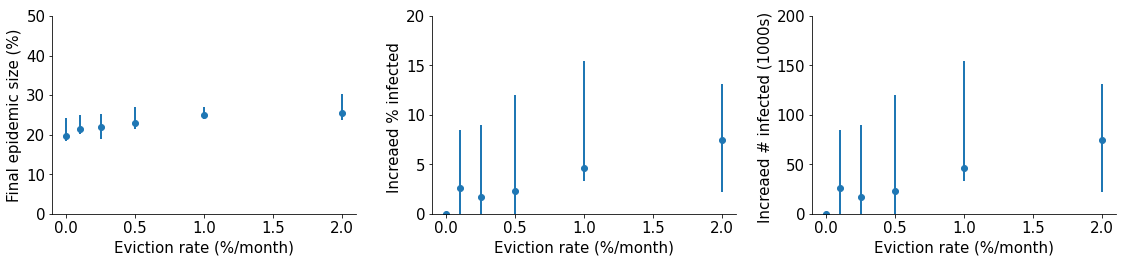

In [44]:
# Final epidemic size

plt.figure(figsize=(2.5*6.4, 4.0))

plt.subplot(131)
FinalSizeRange=[FinalSizeMed-FinalSizeL, FinalSizeU-FinalSizeMed]
plt.errorbar(evictRate,FinalSizeMed,yerr=FinalSizeRange,fmt='o')
plt.xlabel("Eviction rate (%/month)")
plt.ylabel("Final epidemic size (%)")
plt.ylim([0,50])

plt.subplot(132)
delFinalSizeRange=[delFinalSizeMed-delFinalSizeL, delFinalSizeU-delFinalSizeMed]
plt.errorbar(evictRate,delFinalSizeMed,yerr=delFinalSizeRange,fmt='o')
plt.xlabel("Eviction rate (%/month)")
plt.ylabel("Increaed % infected ")
plt.ylim([0,20])

plt.subplot(133)
delFinalSizeRange=[(pop/1e5)*(delFinalSizeMed-delFinalSizeL), (pop/1e5)*(delFinalSizeU-delFinalSizeMed)]
plt.errorbar(evictRate,(pop/1e5)*delFinalSizeMed,yerr=delFinalSizeRange,fmt='o')
plt.xlabel("Eviction rate (%/month)")
plt.ylabel("Increaed # infected (1000s) ")
plt.ylim([0,200])
plt.tight_layout()

plt.show()

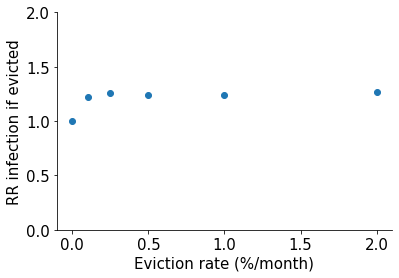

In [42]:
# Relative risk of infection for ppl in merged households
RRinf=probInfMerg/probInfNoMerg
plt.plot(evictRate,RRinf,'o')
plt.xlabel("Eviction rate (%/month)")
plt.ylabel("RR infection if evicted")
plt.ylim([0,2.0])
plt.show()
